# Measuring spectral properties within fixed apertures

While it is more useful to measure global X-ray properties of galaxy clusters within physically motiviated apertures (i.e. using some scale radius such as $R_{500}$), there are cluster studies which have published results measured within fixed apertures. As such, and because it requires essentially no effort on our part to do, we also measure properties within fixed apertures, to provide a point of comparison to those previous studies if it ever becomes necessary.

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented</span>

## Import Statements

In [127]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.tools import luminosity_temperature_pipeline
from xga.relations.fit import scaling_relation_odr, scaling_relation_curve_fit
from xga.models.misc import straight_line, power_law

%matplotlib inline

## Defining the cosmology

We make use of a concordance LambdaCDM model:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in the sample

We need the information from our sample file to declare the XGA ClusterSample further down, primarily the location and redshift, but we also make use of the MCXC estimate of $R_{500}$ to get some idea of the scale of these objects, even if we don't fully trust that measurement:

In [4]:
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
og_samp = samp.copy()
samp['name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes
0,LoVoCCS-0,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L
1,LoVoCCS-1,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN
2,LoVoCCS-2,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L
3,LoVoCCS-3,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN
4,LoVoCCS-4,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr"
...,...,...,...,...,...,...,...,...,...,...,...,...
139,LoVoCCS-139,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr
140,LoVoCCS-140,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN
141,LoVoCCS-141,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X
142,LoVoCCS-142,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN


Here we remove some of the existing columns from the sample, that way they won't be included in the output results file for the LTR run:

In [5]:
del samp['L500']
del samp['R500']
del samp['M500']
del samp['alt_name']
del samp['other_names']
del samp['Notes']

<span style="color:red">This is temporary, gives some better starting coordinates for a few of the clusters, which in turn allows them to better select the correct regions - these will eventually be in the sample file</span>

In [6]:
samp.loc[95, 'ra'] = 240.56
samp.loc[95, 'dec'] = 15.965

samp.loc[130, 'ra'] = 359.713
samp.loc[130, 'dec'] = -60.642

samp.loc[89, 'ra'] = 227.865
samp.loc[89, 'dec'] = 6.349

## Running the XGA $L_{\rm{X}}$-$T_{\rm{X}}$-$R_{500}$ pipeline

<span style="color:red">NOTE TO SELF MEASURE 0.1-2.4keV LUMINOSITIES FOR A MORE DIRECT COMPARISON TO MCXC</span>

In [6]:
res_file = '../../outputs/results/ltr_r500_metfree_pipeline_results.csv'
rhist_file = '../../outputs/results/ltr_r500_metfree_radii_history.csv'


srcs_mfree, results_mfree, rad_hist_mfree = luminosity_temperature_pipeline(samp, Quantity(250, 'kpc'), 
                                                                            timeout=Quantity(4, 'hr'), 
                                                                            freeze_met=False, 
                                                                            save_samp_results_path=res_file, 
                                                                            save_rad_history_path=rhist_file, 
                                                                            core_excised=True, use_peak=False)

Declaring BaseSource Sample:   0%|          | 0/144 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Declaring BaseSource Sample:  57%|█████▋    | 82/144 [02:20<02:09,  2.09s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters:   0%|          | 0/116 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters:  23%|██▎       | 27/116 [03:09<05:08,  3.47s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters:  65%|██████▍   | 75/116 [05:18<01:29,  2.18s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 116/116 [06:52<00:00,  3.56s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/tools/clusters/LT.py:186: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-18, LoVoCCS-24, LoVoCCS-37, LoVoCCS-53, LoVoCCS-54, LoVoCCS-61, LoVoCCS-72, LoVoCCS-87, LoVoCCS-91, LoVoCCS-93, LoVoCCS-98, LoVoCCS-99, LoVoCCS-102, LoVoCCS-105, LoVoCCS-106, LoVoCCS-108, LoVoCCS-109, LoVoCCS-110, LoVoCCS-111, LoVoCCS-112, LoVoCCS-113, LoVoCCS-119, LoVoCCS-122, LoVoCCS-126, LoVoCCS-133, LoVoCCS-137, LoVoCCS-141, LoVoC

In [ ]:
res_file = '../../outputs/results/ltr_r500_pipeline_results.csv'
rhist_file = '../../outputs/results/ltr_r500_radii_history.csv'

srcs, results, rad_hist = luminosity_temperature_pipeline(samp, Quantity(250, 'kpc'), timeout=Quantity(4, 'hr'), 
                                                          freeze_met=True, save_samp_results_path=res_file,
                                                          save_rad_history_path=rhist_file, 
                                                          core_excised=True, use_peak=False)

## Comparing results with MCXC values

In [41]:
results_mfree = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
results = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')

results = results.join(og_samp, 'LoVoCCSID', rsuffix="_right")
results_mfree = results_mfree.join(og_samp, 'LoVoCCSID', rsuffix="_right")

results

,name,MCXC,LoVoCCSID,ra,dec,redshift,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,name_right,MCXC_right,LoVoCCSID_right,ra_right,dec_right,redshift_right,L500,M500,R500,alt_name,other_names,Notes
0,LoVoCCS-0,J1558.3+2713,0,239.585833,27.226944,0.0894,1244.273663,6.70456,0.035456,0.035430,6.639504e+44,1.939629e+43,1.670879e+43,2.485609e+45,9.503753e+43,8.063708e+43,6.74132,0.060204,0.060068,3.707083e+44,2.805471e+43,1.945169e+43,1.391310e+45,8.615253e+43,6.426316e+43,MCXCJ1558.3+2713,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L
1,LoVoCCS-1,J1510.9+0543,1,227.729167,5.720000,0.0766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN
2,LoVoCCS-2,J0258.9+1334,2,44.739583,13.579444,0.0739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L
3,LoVoCCS-3,J1348.8+2635,3,207.220833,26.595556,0.0622,942.788397,4.37461,0.023899,0.023820,3.722851e+44,6.813599e+41,5.490954e+41,1.141321e+45,3.839272e+42,3.328101e+42,4.51626,0.046986,0.046763,1.876619e+44,6.143515e+41,5.160761e+41,5.838537e+44,3.524215e+42,4.147552e+42,MCXCJ1348.8+2635,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN
4,LoVoCCS-4,J0041.8-0918,4,10.458750,-9.301944,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,LoVoCCS-136,J1413.7+4339,136,213.431250,43.663333,0.0890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCXCJ1413.7+4339,J1413.7+4339,136,213.431250,43.663333,0.0890,1.023860,1.9516,0.8573,RXCJ1413.7+4339,A1885,NaN
111,LoVoCCS-138,J1359.2+2758,138,209.822917,27.972778,0.0612,796.482879,3.65152,0.060575,0.055262,7.589574e+43,1.346388e+42,1.487723e+42,2.144301e+44,4.849442e+42,4.547660e+42,3.36455,0.068141,0.068968,4.983137e+43,1.405412e+42,1.479828e+42,1.358673e+44,4.561647e+42,4.412017e+42,MCXCJ1359.2+2758,J1359.2+2758,138,209.822917,27.972778,0.0612,1.016556,1.9807,0.8693,RXCJ1359.2+2758,A1831,NaN
112,LoVoCCS-139,J0448.2-2028,139,72.050833,-20.469722,0.0720,902.565467,3.72820,0.125515,0.132308,4.501135e+43,8.160091e+41,7.012458e+41,1.283544e+44,2.663591e+42,3.912081e+42,3.70188,0.129654,0.141818,4.090309e+43,8.806538e+41,9.345118e+41,1.162735e+44,3.630786e+42,3.614687e+42,MCXCJ0448.2-2028,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr
113,LoVoCCS-140,J2323.8+1648,140,350.972917,16.808889,0.0416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCXCJ2323.8+1648,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN


In [49]:
results = results[~(results['name'] == 'LoVoCCS-47')]

In [92]:
lx_comp = scaling_relation_curve_fit(straight_line, Quantity(results['Lx500_0.5-2.0'], 'erg/s'), 
                                     Quantity(results[['Lx500_0.5-2.0-', 'Lx500_0.5-2.0+']], 'erg/s'), 
                                     Quantity(results['L500']*1e+44, 'erg/s'), y_norm=Quantity(1e+44, 'erg/s'), 
                                     x_norm=Quantity(1e+44, 'erg/s'), point_names=results['name'].values, 
                                     y_name=r'$L^{0.5-2.0\rm{keV}}_{\rm{XMM},500}$', 
                                     x_name=r'$L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', 
                                     third_dim_info=results['redshift'].values, third_dim_name='Redshift')

/mnt/ufs18/home-218/turne540/code/XGA/xga/relations/fit.py:83: UserWarning: 29 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


<span style="color:red">Grids like this make me irrationally angry, but I get a matplotlib error if I use the default `grid_on=False` argument.</span> 

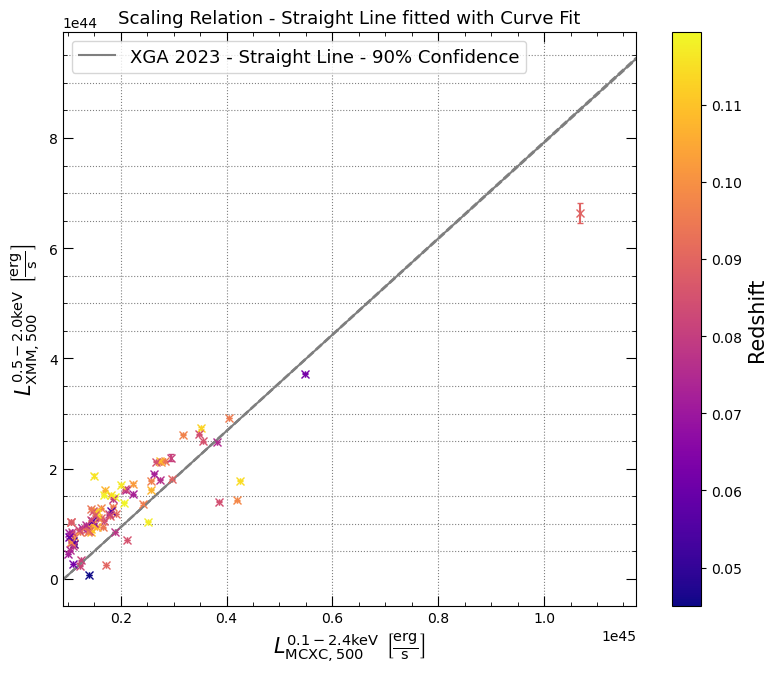

['gradient', 'intercept']


array([[ 8.73159993e-01,  7.55994297e-04],
       [-8.09359111e-01,  1.29266310e-03]])

In [99]:
lx_comp.view(grid_on=True, figsize=(8, 7), label_points=False, log_scale=False,
             save_path='../../outputs/figures/global_properties/xmm_mcxc_lx_comp.pdf')
print(lx_comp.par_names)
lx_comp.pars

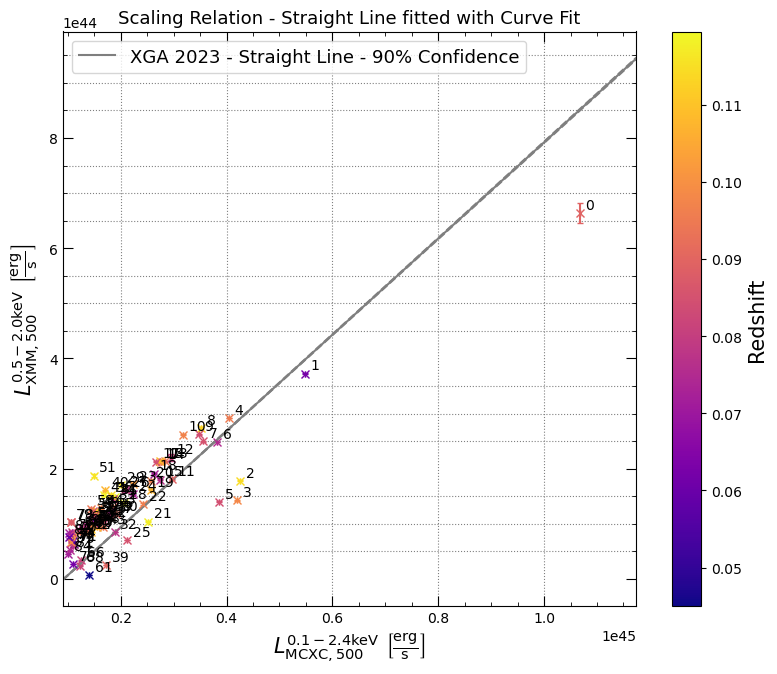

array(['LoVoCCS-0', 'LoVoCCS-3', 'LoVoCCS-5', 'LoVoCCS-6', 'LoVoCCS-7',
       'LoVoCCS-9', 'LoVoCCS-12', 'LoVoCCS-14', 'LoVoCCS-16',
       'LoVoCCS-17', 'LoVoCCS-19', 'LoVoCCS-21', 'LoVoCCS-22',
       'LoVoCCS-23', 'LoVoCCS-25', 'LoVoCCS-27', 'LoVoCCS-28',
       'LoVoCCS-30', 'LoVoCCS-31', 'LoVoCCS-33', 'LoVoCCS-34',
       'LoVoCCS-35', 'LoVoCCS-36', 'LoVoCCS-38', 'LoVoCCS-39',
       'LoVoCCS-40', 'LoVoCCS-41', 'LoVoCCS-42', 'LoVoCCS-43',
       'LoVoCCS-44', 'LoVoCCS-45', 'LoVoCCS-48', 'LoVoCCS-49',
       'LoVoCCS-50', 'LoVoCCS-52', 'LoVoCCS-55', 'LoVoCCS-56',
       'LoVoCCS-57', 'LoVoCCS-58', 'LoVoCCS-59', 'LoVoCCS-60',
       'LoVoCCS-62', 'LoVoCCS-63', 'LoVoCCS-65', 'LoVoCCS-67',
       'LoVoCCS-68', 'LoVoCCS-70', 'LoVoCCS-71', 'LoVoCCS-73',
       'LoVoCCS-74', 'LoVoCCS-75', 'LoVoCCS-76', 'LoVoCCS-77',
       'LoVoCCS-79', 'LoVoCCS-80', 'LoVoCCS-81', 'LoVoCCS-83',
       'LoVoCCS-84', 'LoVoCCS-86', 'LoVoCCS-88', 'LoVoCCS-89',
       'LoVoCCS-90', 'LoVoCCS-92', 'LoVoCCS-94'

In [97]:
lx_comp.view(grid_on=True, figsize=(8, 7), label_points=True, log_scale=False)
lx_comp.point_names

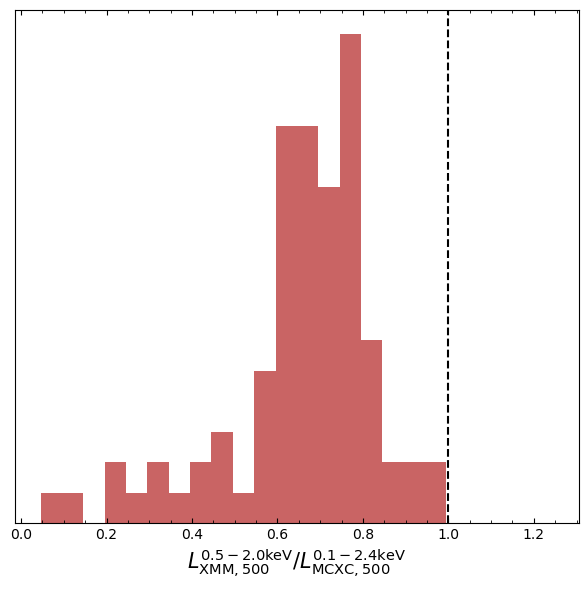

In [144]:
lx_rat = lx_comp.y_data[:, 0] / lx_comp.x_data[:, 0]

bins = np.arange(lx_rat.min(), lx_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(lx_rat, bins=bins, color='firebrick', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.yticks([])
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$L^{0.5-2.0\rm{keV}}_{\rm{XMM},500} / L^{0.1-2.4\rm{keV}}_{\rm{MCXC},500}$', fontsize=15)
plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_lx_ratio.pdf')
plt.show()

<span style="color:red">I am daft and the pipeline doesn't currently save radius uncertainties from the iterative process, so I need to do that - in the meantime I have just assumed very small errors (as they probably will be from these clusters, rightly or wrongly)</span> 

In [118]:
r500_comp = scaling_relation_curve_fit(straight_line, Quantity(results['r500'], 'kpc'), 
                                       Quantity([10]*len(results), 'kpc'), 
                                       Quantity(results['R500'], 'Mpc').to('kpc'), y_norm=Quantity(1, 'kpc'), 
                                       x_norm=Quantity(1, 'kpc'), point_names=results['name'].values, 
                                       y_name=r'$R^{\rm{XMM}}_{500}$', 
                                       x_name=r'$R^{\rm{MCXC}}_{500}$', 
                                       third_dim_info=results['redshift'].values, third_dim_name='Redshift')

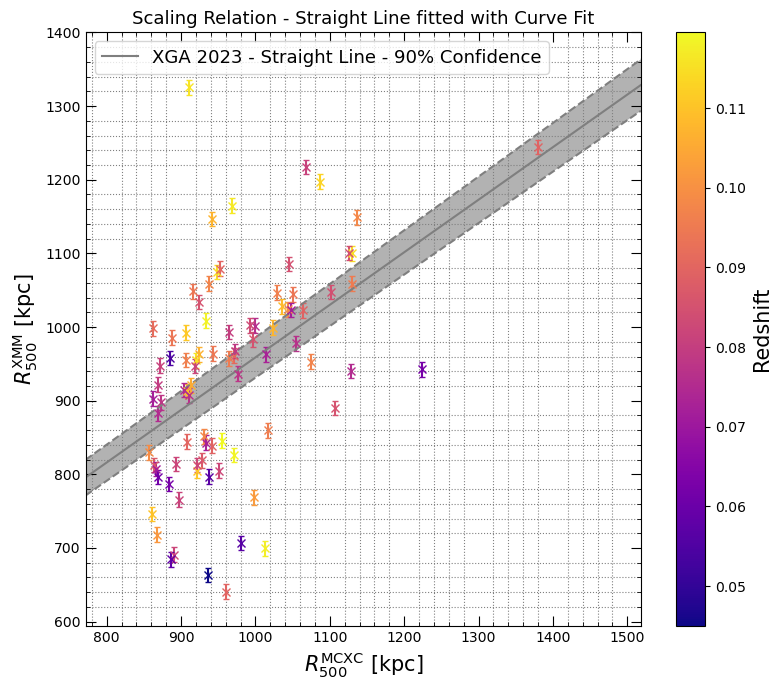

['gradient', 'intercept']


array([[7.13522867e-01, 1.17369820e-02],
       [2.45300596e+02, 1.14221696e+01]])

In [120]:
r500_comp.view(grid_on=True, figsize=(8, 7), label_points=False, log_scale=False,
             save_path='../../outputs/figures/global_properties/xmm_mcxc_r500_comp.pdf')

print(r500_comp.par_names)
r500_comp.pars

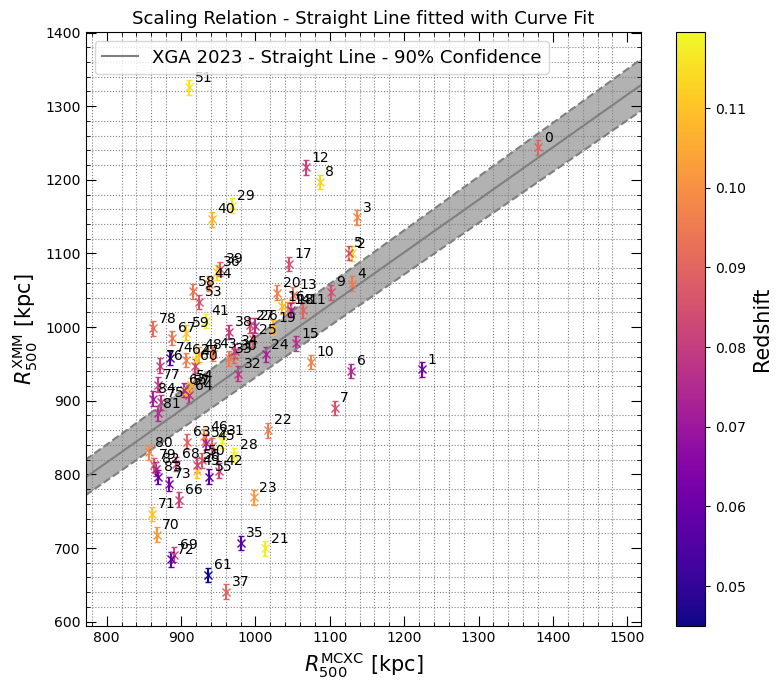

array(['LoVoCCS-0', 'LoVoCCS-3', 'LoVoCCS-5', 'LoVoCCS-6', 'LoVoCCS-7',
       'LoVoCCS-9', 'LoVoCCS-12', 'LoVoCCS-14', 'LoVoCCS-16',
       'LoVoCCS-17', 'LoVoCCS-19', 'LoVoCCS-21', 'LoVoCCS-22',
       'LoVoCCS-23', 'LoVoCCS-25', 'LoVoCCS-27', 'LoVoCCS-28',
       'LoVoCCS-30', 'LoVoCCS-31', 'LoVoCCS-33', 'LoVoCCS-34',
       'LoVoCCS-35', 'LoVoCCS-36', 'LoVoCCS-38', 'LoVoCCS-39',
       'LoVoCCS-40', 'LoVoCCS-41', 'LoVoCCS-42', 'LoVoCCS-43',
       'LoVoCCS-44', 'LoVoCCS-45', 'LoVoCCS-48', 'LoVoCCS-49',
       'LoVoCCS-50', 'LoVoCCS-52', 'LoVoCCS-55', 'LoVoCCS-56',
       'LoVoCCS-57', 'LoVoCCS-58', 'LoVoCCS-59', 'LoVoCCS-60',
       'LoVoCCS-62', 'LoVoCCS-63', 'LoVoCCS-65', 'LoVoCCS-67',
       'LoVoCCS-68', 'LoVoCCS-70', 'LoVoCCS-71', 'LoVoCCS-73',
       'LoVoCCS-74', 'LoVoCCS-75', 'LoVoCCS-76', 'LoVoCCS-77',
       'LoVoCCS-79', 'LoVoCCS-80', 'LoVoCCS-81', 'LoVoCCS-83',
       'LoVoCCS-84', 'LoVoCCS-86', 'LoVoCCS-88', 'LoVoCCS-89',
       'LoVoCCS-90', 'LoVoCCS-92', 'LoVoCCS-94'

In [124]:
r500_comp.view(grid_on=True, figsize=(8, 7), label_points=True, log_scale=False)
r500_comp.point_names

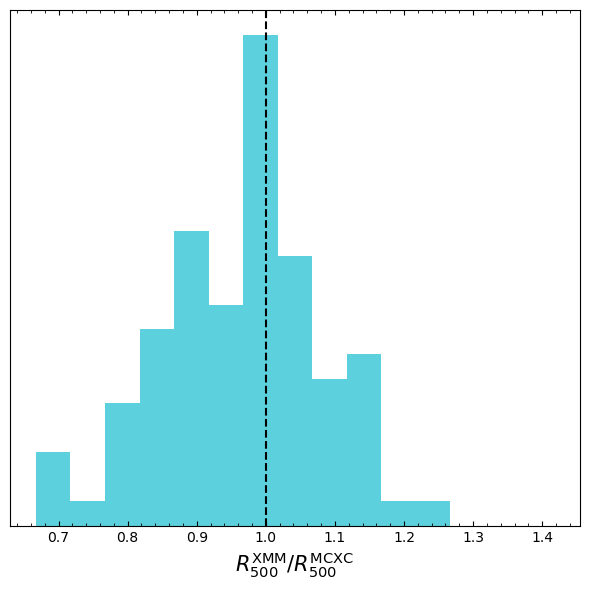

In [140]:
r500_rat = r500_comp.y_data[:, 0] / r500_comp.x_data[:, 0]

bins = np.arange(r500_rat.min(), r500_rat.max(), 0.05)

plt.figure(figsize=(6, 6))
plt.hist(r500_rat, bins=bins, color='tab:cyan', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.yticks([])
plt.axvline(1, linestyle='dashed', color='black')
plt.xlabel(r'$R^{\rm{XMM}}_{500} / R^{\rm{MCXC}}_{500}$', fontsize=15)

plt.tight_layout()
plt.savefig('../../outputs/figures/global_properties/xmm_mcxc_r500_ratio.pdf')
plt.show()